In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features
from sklearn.preprocessing import StandardScaler
from pylab import rcParams


# Data set of NANOSTRING

In [144]:

df = pd.read_csv()
columns = df.columns
columns = [i.replace(" ", "_") for i in columns]
df.columns = columns
variables = df.columns.tolist()
variables_bx = []
var_combs =  []
array_split = list(map(lambda x: x.split("_"), variables))
for i in range(len(array_split)):
    if "bx" in array_split[i]:
        variables_bx.append(variables[i])
        
df_top = df[variables_bx].dropna()
########## Dataset anonymization ################
# Create an empty dictionary to store the original and new column names
dict_genes = {}

# Iterate over the columns of the DataFrame
for i, col in enumerate(df_top.columns):
    # Create the new column name as "BSC_BM" followed by the index
    new_col = f"BSC_BM{i+1}"
    # Add the original and new column names to the dictionary
    dict_genes[col] = new_col
    # Rename the column in the DataFrame
    df_top.rename(columns={col: new_col}, inplace=True)


## Features with low variability¶



In [39]:
constant_features = get_constant_features(df_nano_bx, threshold=0.85)
display_all(constant_features)# All the constant features stored in a list


,Desc,Var,Value,Perc


In [143]:
matrix = df_nano_bx.corr()
matrix = matrix.unstack()
matrix = matrix[abs(matrix) <= 0.85]

print(matrix)

BSC_BM1    BSC_BM2      0.027214
           BSC_BM3      0.087745
           BSC_BM4      0.127876
           BSC_BM5      0.013259
           BSC_BM6      0.179856
                          ...   
BSC_BM232  BSC_BM227   -0.141446
           BSC_BM228    0.134850
           BSC_BM229    0.274934
           BSC_BM230    0.419729
           BSC_BM231    0.815767
Length: 53312, dtype: float64


## Correlated features

In [151]:

df1 = pd.DataFrame()
feat1s = []
feat2s = []
corrs = []
p_values = []

for feat1 in df_top.columns:
    for feat2 in df_top.columns:
        if feat1 != feat2:
            feat1s.append(feat1)
            feat2s.append(feat2)
            corr, p_value = scipy.stats.spearmanr(df_top[feat1], df_top[feat2])
            corrs.append(corr)
            p_values.append(p_value)

df1['Feature_1'] = feat1s
df1['Feature_2'] = feat2s
df1['Correlation'] = corrs
df1['p_value'] = p_values



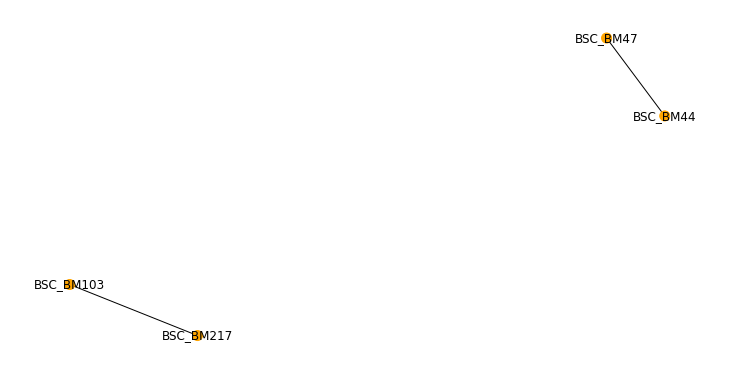

In [157]:
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=df1.loc[ (df1['Correlation'] > 0.95) & (df1['p_value'] < 0.005) & (df1['Feature_1'] != df1['Feature_2']) ]
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'Feature_1', 'Feature_2')
rcParams['figure.figsize'] = 10, 5
pos = nx.spring_layout(G, scale=5, k=2/np.sqrt(G.order()))
d = dict(G.degree)
nx.draw(G, pos, node_color='orange', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*100 for k in d])
